In [26]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Move to project root
from pathlib import Path
import os

if not Path("./src/models").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/models").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/models").is_dir()

In [33]:
def preprocess_data(
    data: pl.DataFrame, metric: str = "acc", low: float = 0.05, high: float = 0.95
):
    return (
        data.select(
            pl.all()
            .implode()
            .list.eval(
                pl.struct(
                    mean=pl.element().struct.field(metric).mean(),
                    high=pl.element().struct.field(metric).quantile(high),
                    low=pl.element().struct.field(metric).quantile(low),
                )
            )
            .list.get(0)
        )
        .transpose(include_header=True, column_names=["metric"], header_name="kind")
        .lazy()
        .unnest("metric")
        .with_columns(
            pl.col("kind").str.split_exact("-", 2),
            grouped=pl.col("kind").str.contains("gsize2"),
            closing=pl.col("kind").str.contains("closing"),
        )
        .select(
            pl.col("kind")
            .struct[0]
            .add(
                pl.when(pl.col("kind").struct[2].is_not_null())
                .then(pl.lit("-").add(pl.col("kind").struct[2]))
                .otherwise(pl.lit(""))
            )
            .alias("kind"),
            pl.col("kind").struct[1].cast(int).alias("size"),
            "grouped",
            "closing",
            "low",
            "mean",
            "high",
        )
        .collect()
    )


km_pre = preprocess_data(pl.read_parquet("./.data/long_k_mnist.pq"), metric="acc")
km_pre

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""standard""",1,false,false,0.932834,0.938967,0.946072
"""standard""",2,false,false,0.947157,0.954781,0.961589
"""standard""",3,false,false,0.949002,0.95621,0.962782
"""standard""",4,false,false,0.943793,0.954438,0.963108
"""standard""",5,false,false,0.928277,0.945018,0.95638
…,…,…,…,…,…,…
"""aniso-skewed""",5,false,false,0.95421,0.960489,0.966146
"""aniso-ss""",7,false,false,0.955621,0.961899,0.966797
"""aniso-skewed""",7,false,false,0.954861,0.961609,0.967882


In [5]:
# missing_zeroes = pl.DataFrame(
#     {
#         "kind": [
#             "standard",
#             "standard",
#             "standard",
#             "iso-ss",
#             "aniso-ss",
#             "aniso-skewed",
#         ],
#         "size": [1, 2, 4, 2, 2, 2],
#         "grouped": [False] * 6,
#         "closing": [False] * 6,
#         "low": [0.0] * 6,
#         "mean": [0.0] * 6,
#         "high": [0.0] * 6,
#     }
# )
# missing_zeroes

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""standard""",1,false,false,0.0,0.0,0.0
"""standard""",2,false,false,0.0,0.0,0.0
"""standard""",4,false,false,0.0,0.0,0.0
"""iso-ss""",2,false,false,0.0,0.0,0.0
"""aniso-ss""",2,false,false,0.0,0.0,0.0
"""aniso-skewed""",2,false,false,0.0,0.0,0.0


In [10]:
km_pre = km_pre_part.vstack(missing_zeroes).sort(
    "kind", pl.col("size").neg(), descending=True
)
km_pre

kind,size,grouped,closing,low,mean,high
str,i64,bool,bool,f64,f64,f64
"""standard""",1,false,false,0.0,0.0,0.0
"""standard""",2,false,false,0.0,0.0,0.0
"""standard""",3,false,false,0.949327,0.955834,0.963108
"""standard""",4,false,false,0.0,0.0,0.0
"""standard""",5,false,false,0.926541,0.944839,0.958008
…,…,…,…,…,…,…
"""aniso-skewed""",2,false,false,0.0,0.0,0.0
"""aniso-skewed""",3,false,false,0.950087,0.958651,0.964735
"""aniso-skewed""",5,false,false,0.953016,0.960623,0.967122


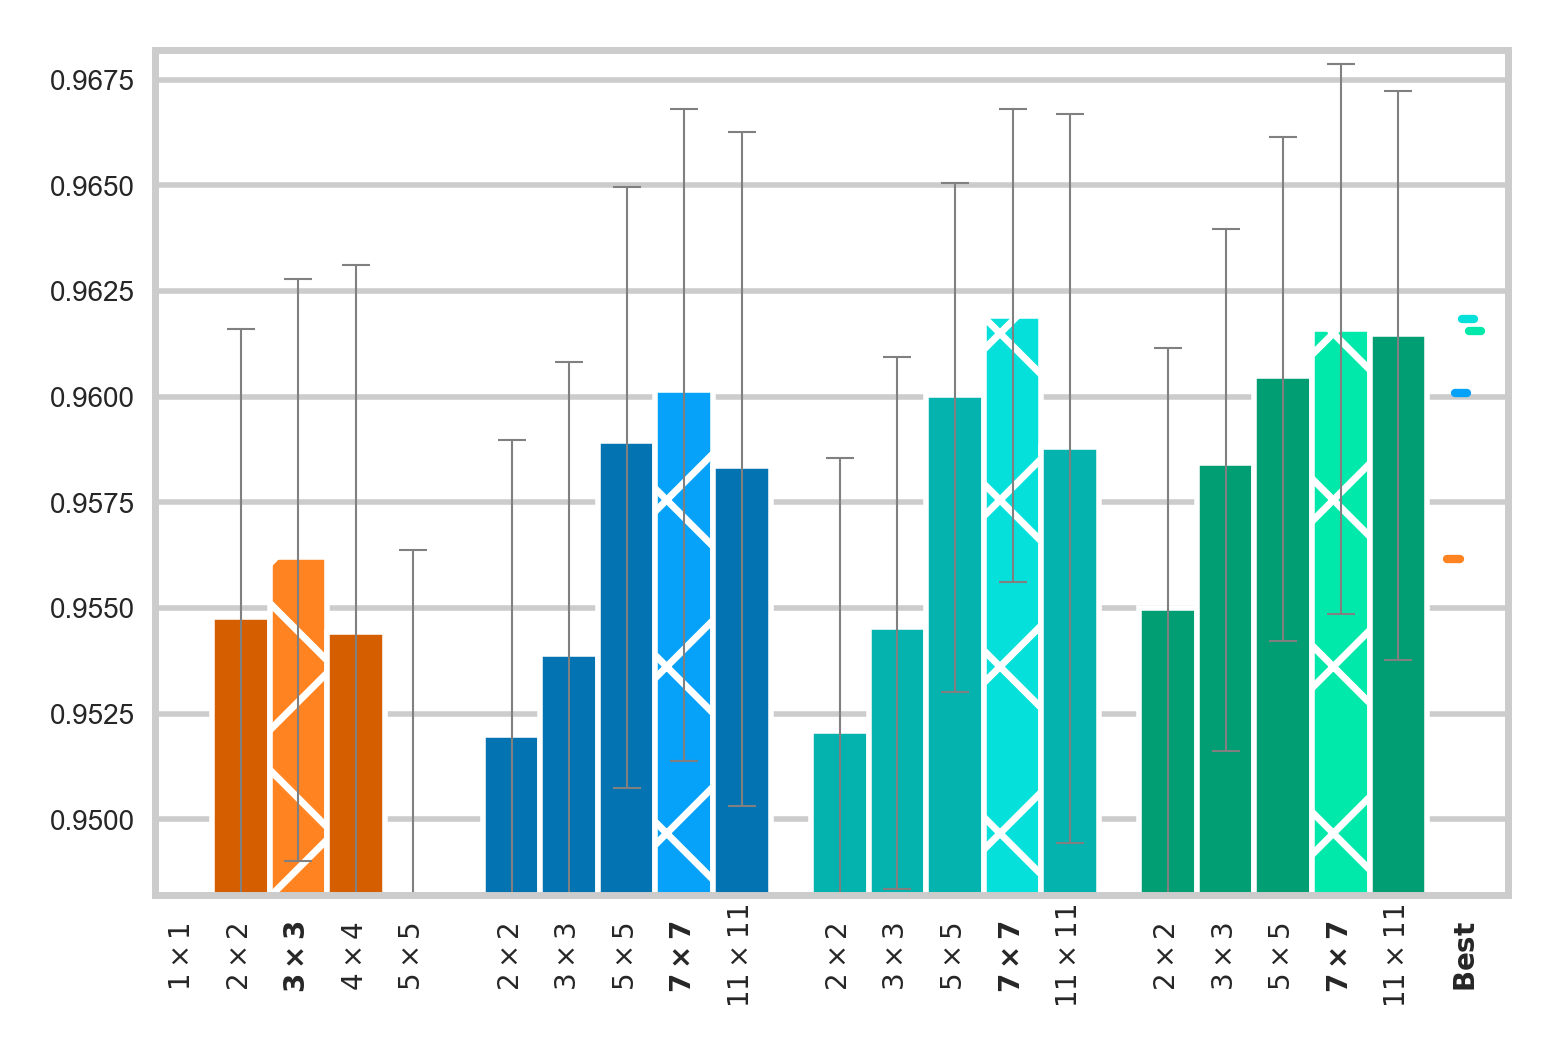

In [5]:
def plot_group_kernel_size(
    ax: plt.Axes,
    tick_positions: list[float],
    tick_labels: list[str],
    group: pl.DataFrame,
    color: str,
    begin: float,
    width: float,
    highlight: str = None,
    higher_is_better: bool = True,
):
    best = (
        group.with_row_index()
        .filter(pl.col("mean").ne(0))
        .top_k(1, by="mean", reverse=not higher_is_better)
        .item(0, column="index")
    )
    x = begin
    for i, (_kind, size, _grp, _cls, low, mean, high) in enumerate(group.iter_rows()):
        ax.bar(
            x,
            mean,
            width,
            align="edge",
            color=highlight if highlight and i == best else color,
            hatch="x" if highlight and i == best else "",
        )
        ax.errorbar(
            x + width / 2,
            min(max(mean, low), high),
            ((mean - low if mean > low else 0,), (high - mean if high > mean else 0,)),
            color="grey",
            capsize=2,
            linewidth=0.3,
            capthick=0.3,
        )
        tick_positions.append(x + width / 2)
        if i == best:
            label = rf"$\mathbf{{{size}\times{size}}}$"
        else:
            label = rf"${size}\times{size}$"
        tick_labels.append(label)
        x += width


def plot_results(
    group_plotter,
    data: pl.DataFrame,
    baseline: tuple[str, int] = ("standard", 1),
    baseline_height: float = 0.4,
    total_height: float = 2 / 100,
    figsize: tuple[float, float] = (3, 2),
    group_gap: float = 0.03,
    higher_is_better: bool = True,
    save_path: str = None,
    x_tick_pad=4.0,
    ylim: tuple[float, float] = None,
):
    sns.set_theme("paper", "whitegrid")
    fig, ax = plt.subplots(layout="compressed", figsize=figsize, dpi=500)
    if ylim is None:
        bot = (
            data.filter(
                pl.col("kind").eq(baseline[0]) & pl.col("size").eq(baseline[1])
            ).item(0, "mean")
        ) - (baseline_height * total_height)
        ax.set_ylim(bot, bot + total_height)
    else:
        ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(0, 1)
    n_groups = data.n_unique("kind")
    total_bar_space = 1.0 - group_gap * (n_groups + 1)
    per_bar_space = total_bar_space / len(data)
    best_stripes_start = 1.0 - group_gap * 1.5
    best_stripes_len = group_gap * 0.3
    best_stripes_step = group_gap * 0.7 / n_groups
    colors = {
        "standard": ("#D55E00", "#FF8320"),
        "iso-ss": ("#0473B2", "#06A1F9"),
        "aniso-ss": ("#04B2AE", "#05E0DB"),
        "aniso-skewed": ("#019E73", "#01E9AA"),
    }

    x = 0
    tick_positions, tick_labels = [], []
    for grp_i, (name, (color, highlight)) in enumerate(colors.items()):
        group = data.filter(pl.col("kind").eq(name))
        if len(group) == 0:
            continue

        group_plotter(
            ax,
            tick_positions,
            tick_labels,
            group,
            color=color,
            begin=x,
            width=per_bar_space,
            highlight=highlight,
            higher_is_better=higher_is_better,
        )
        high = (
            group.filter(pl.col("mean").ne(0))
            .top_k(1, by="mean", reverse=not higher_is_better)
            .item(0, column="mean")
        )
        stripe_start = best_stripes_start + best_stripes_step * grp_i
        ax.plot(
            (stripe_start, stripe_start + best_stripes_len),
            # Matplotlib draws the lines *slightly* off-centre...
            (high - 0.00006, high - 0.00006),
            color=highlight,
            # linestyle="dashed",
        )
        x += group_gap + per_bar_space * len(group)

    tick_positions.append(best_stripes_start + group_gap / 2)
    tick_labels.append(r"$\mathbf{Best}$")
    ax.set_xticks(tick_positions, tick_labels, rotation=90, va="center")
    ax.tick_params(labelsize=4)
    for tick in ax.get_xaxis().get_major_ticks():
        tick.set_pad(x_tick_pad)
    for tick in ax.get_yaxis().get_major_ticks():
        tick.set_pad(-2.0)
    ax.grid(False, axis="x")

    if save_path is not None:
        fig.savefig(save_path)


plot_results(
    plot_group_kernel_size,
    km_pre,
    save_path="./report/figures/results_k_mnist.png",
    baseline=("standard", 3),
)
plt.show()

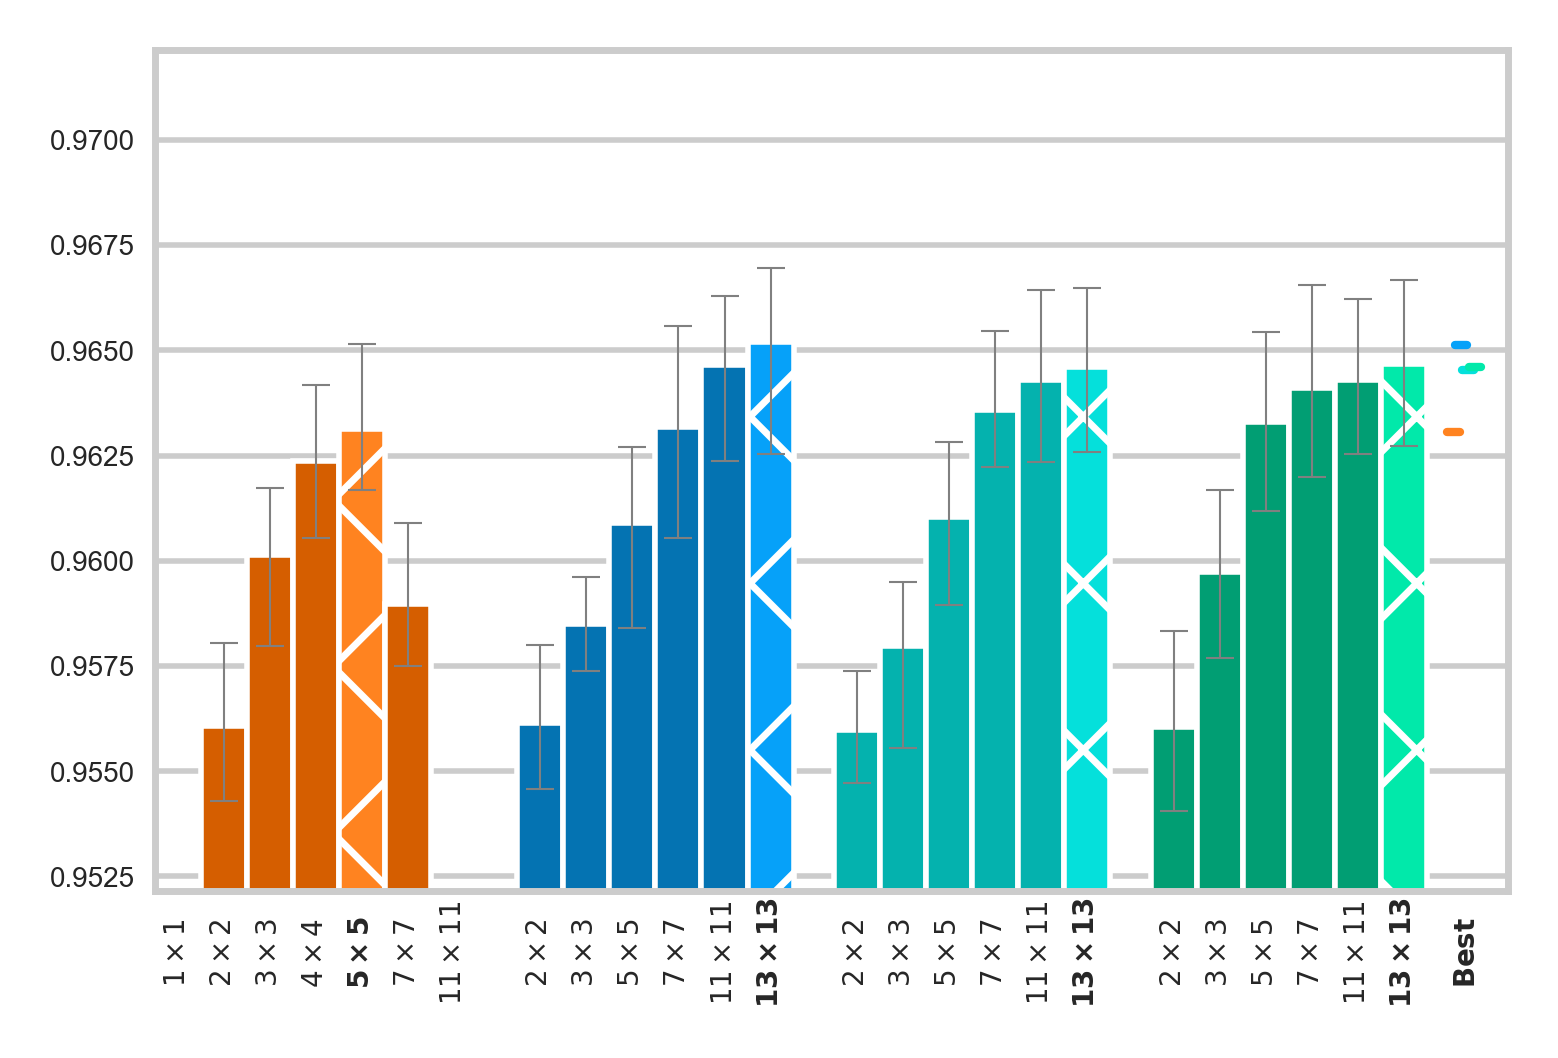

In [16]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(
        pl.read_parquet("./.data/long_svhn.pq").hstack(
            pl.read_parquet("./.data/extra_svhn.pq")
        )
    ).sort("kind", pl.col("size").neg(), descending=True),
    save_path="./report/figures/results_svhn.png",
    baseline=("standard", 3),
)
plt.show()

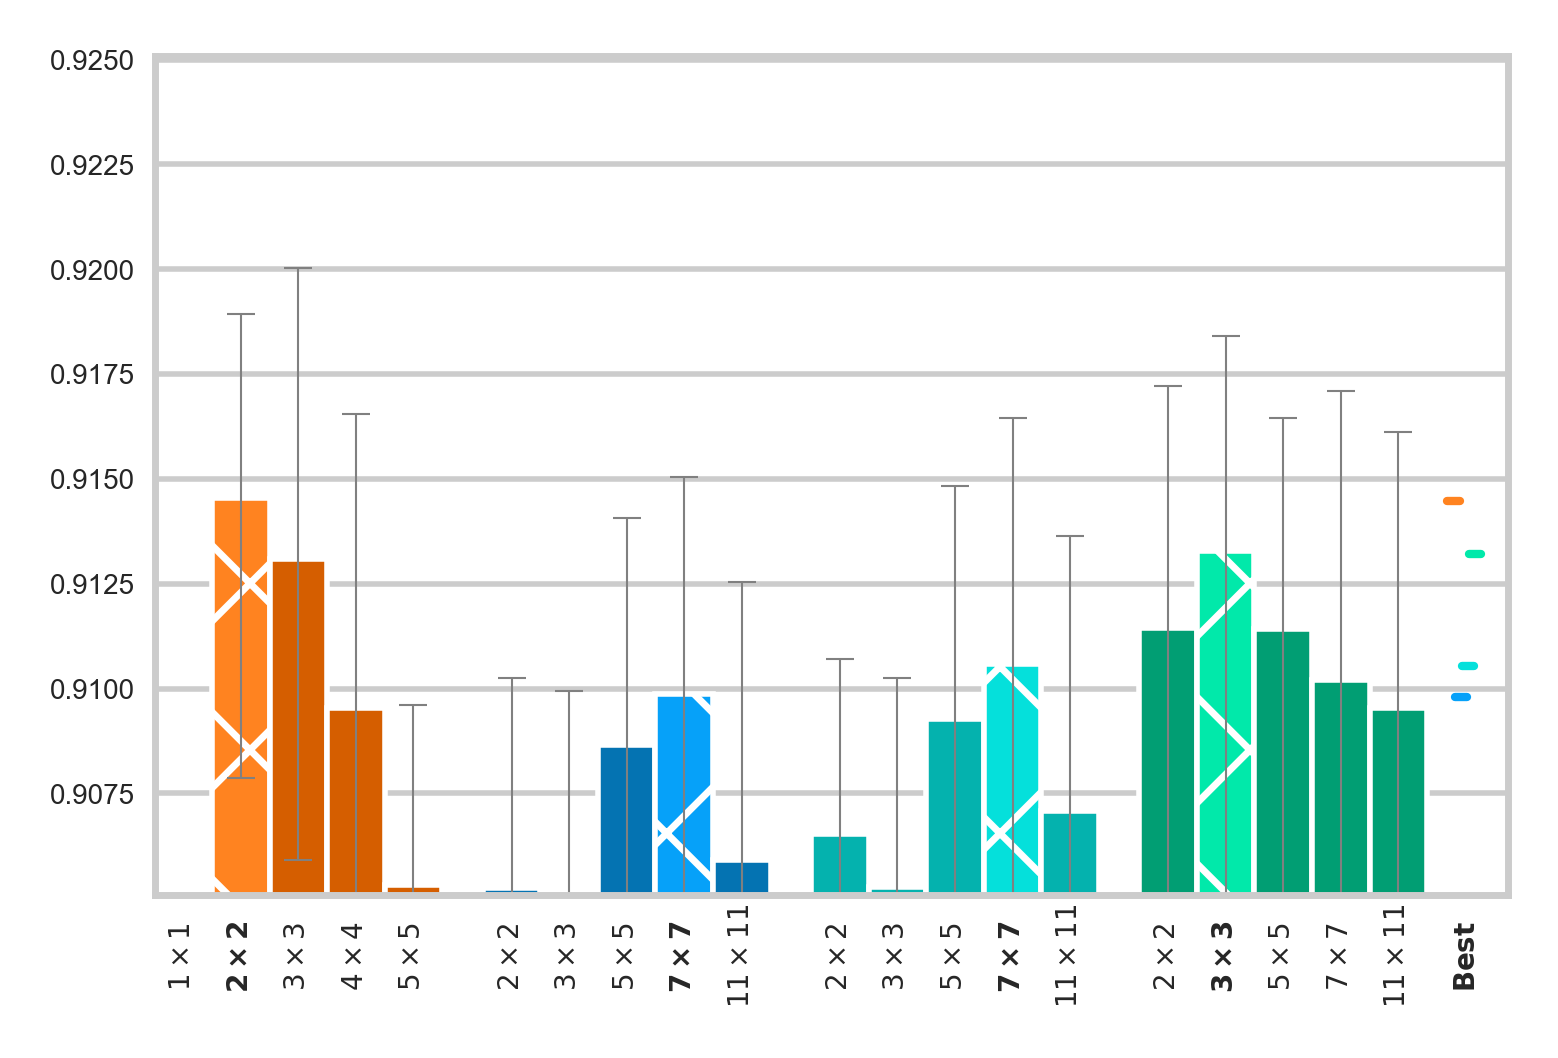

In [13]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(pl.read_parquet("./.data/long_fashion.pq")),
    save_path="./report/figures/results_fashion.png",
    baseline=("standard", 3),
)
plt.show()

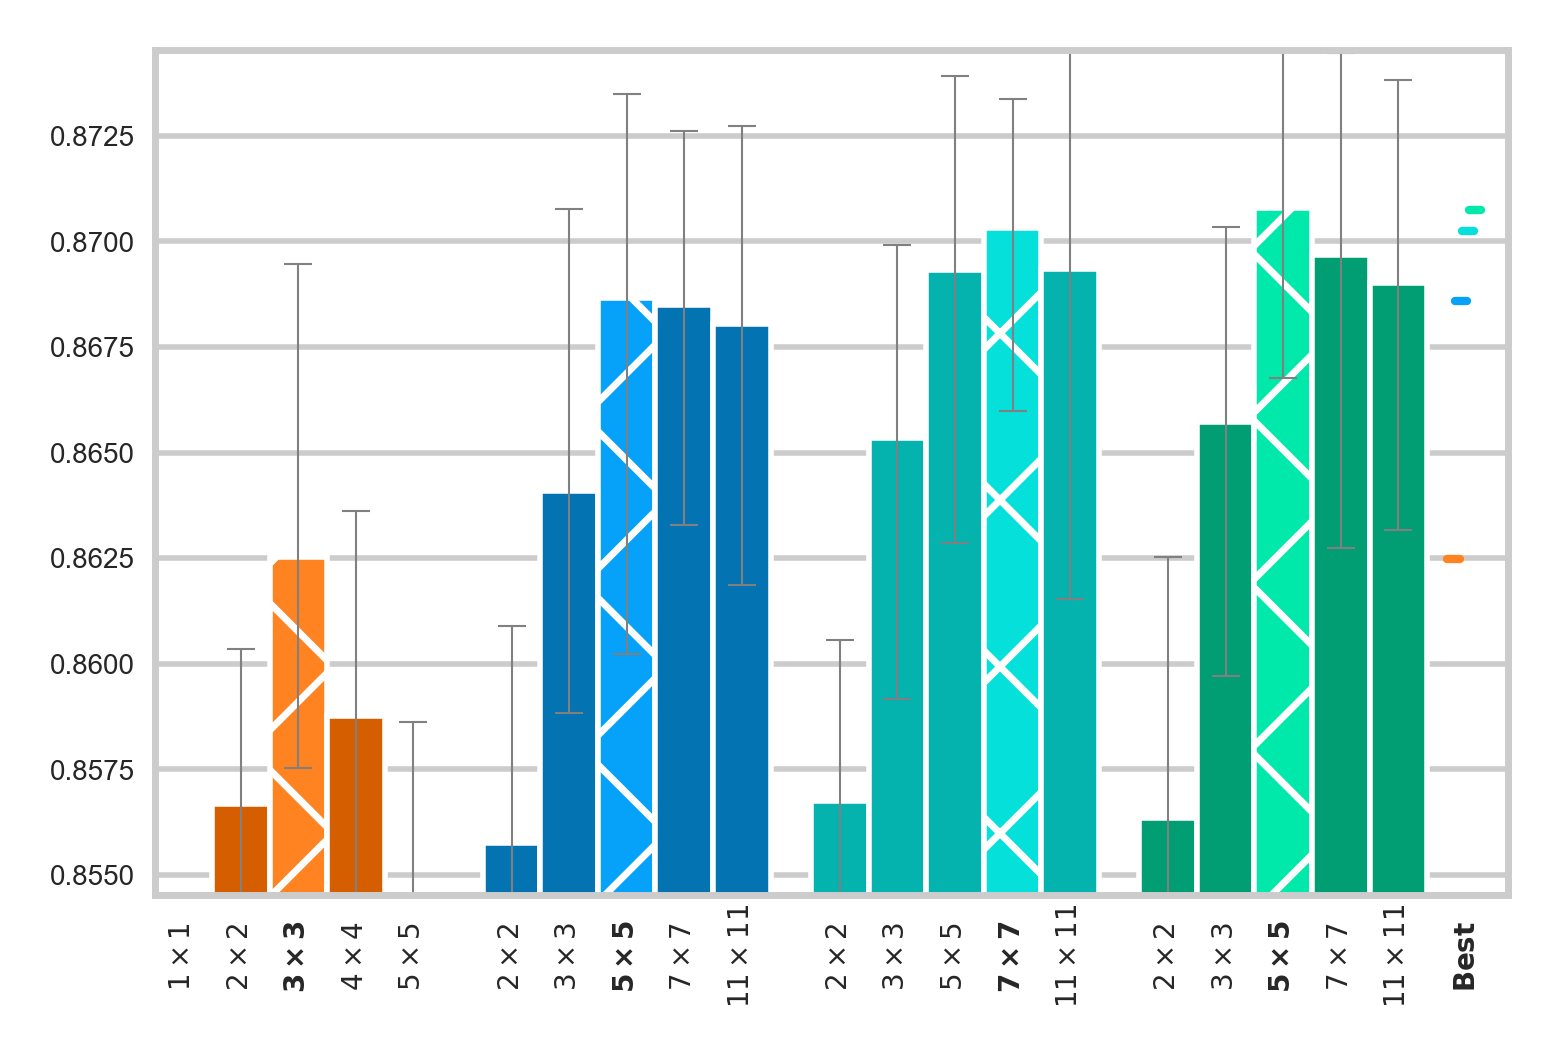

In [17]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(
        pl.read_parquet("./.data/long_cifar10.pq").hstack(
            pl.read_parquet("./.data/extra_cifar10.pq")
        )
    ).sort("kind", pl.col("size").neg(), descending=True),
    save_path="./report/figures/results_cifar10.png",
    baseline=("standard", 3),
)
plt.show()

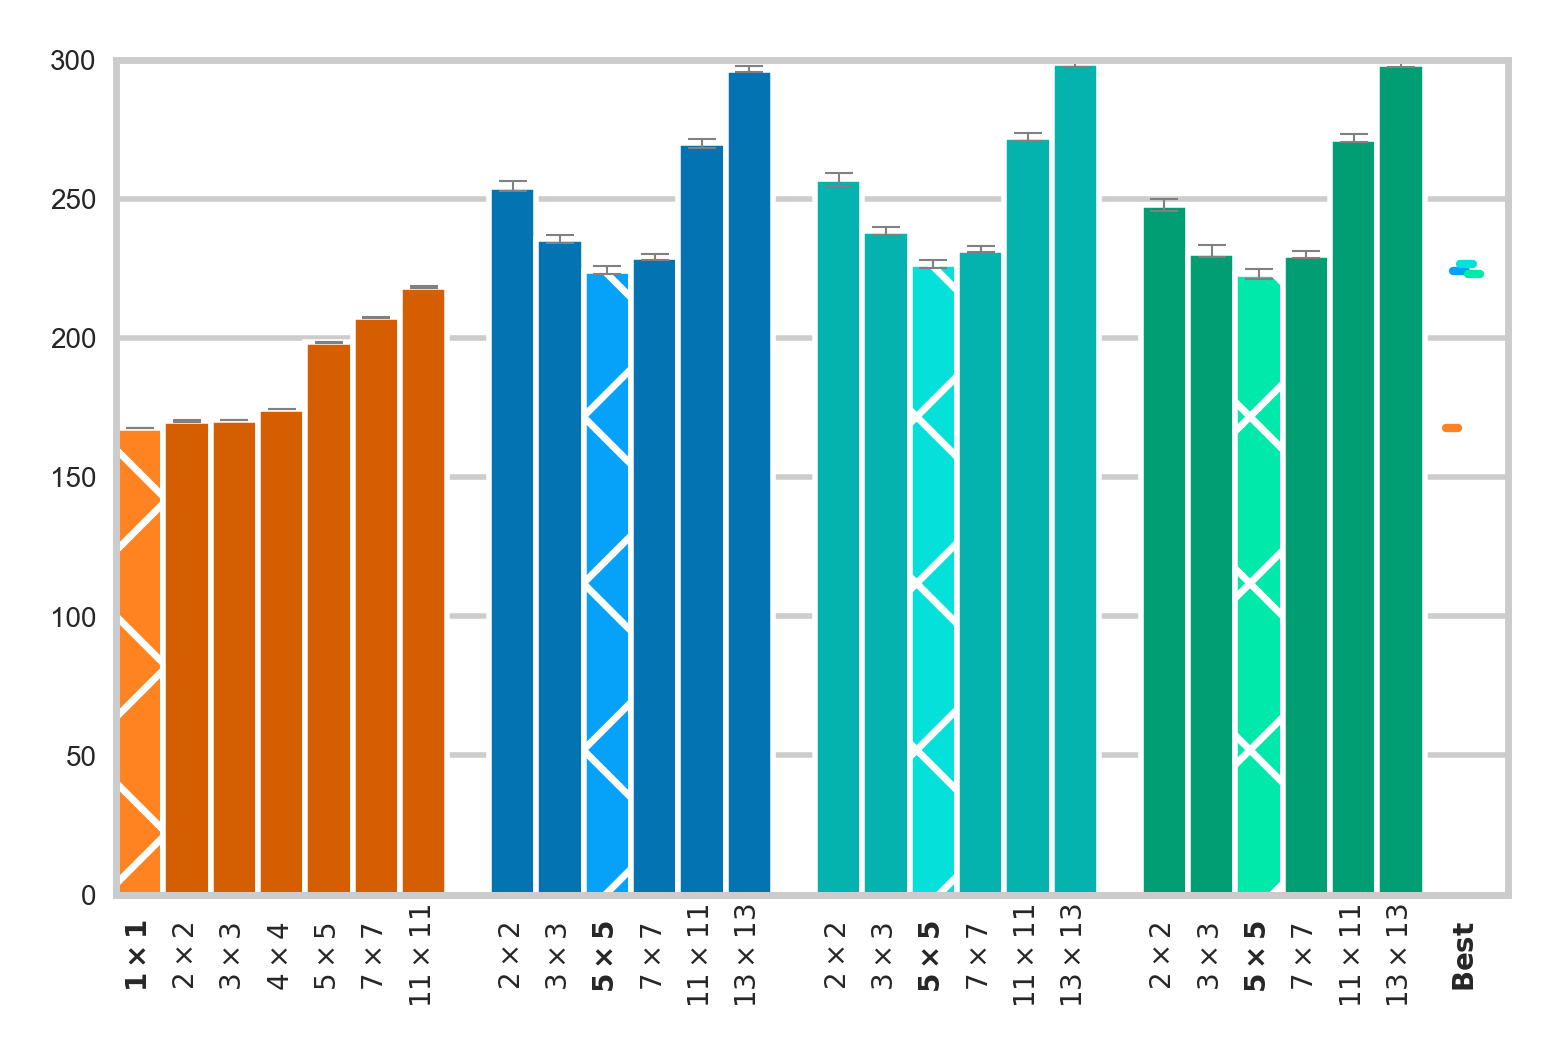

In [18]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(
        pl.read_parquet("./.data/long_svhn.pq").hstack(
            pl.read_parquet("./.data/extra_svhn.pq")
        ),
        metric="train_times",
    ),
    save_path="./report/figures/timings_svhn.png",
    higher_is_better=False,
    ylim=(0, 300),
)
plt.show()

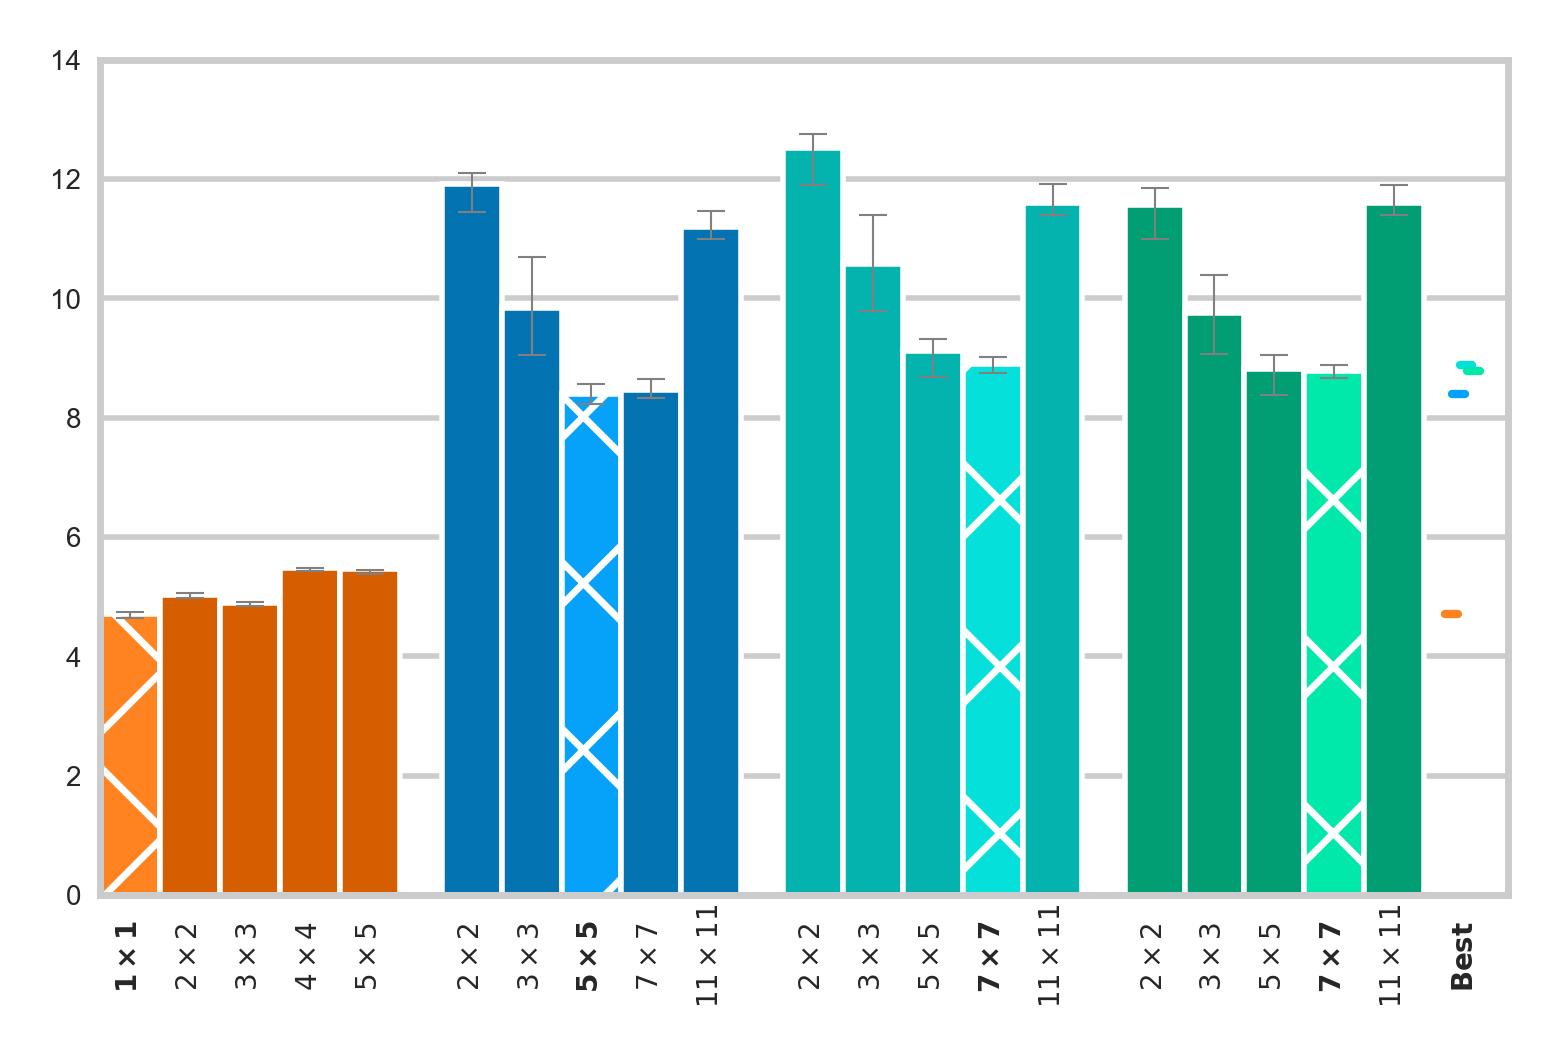

In [25]:
plot_results(
    plot_group_kernel_size,
    preprocess_data(pl.read_parquet("./.data/long_fashion.pq"), metric="train_times"),
    save_path="./report/figures/timings_fashion.png",
    higher_is_better=False,
    ylim=(0, 14),
)
plt.show()

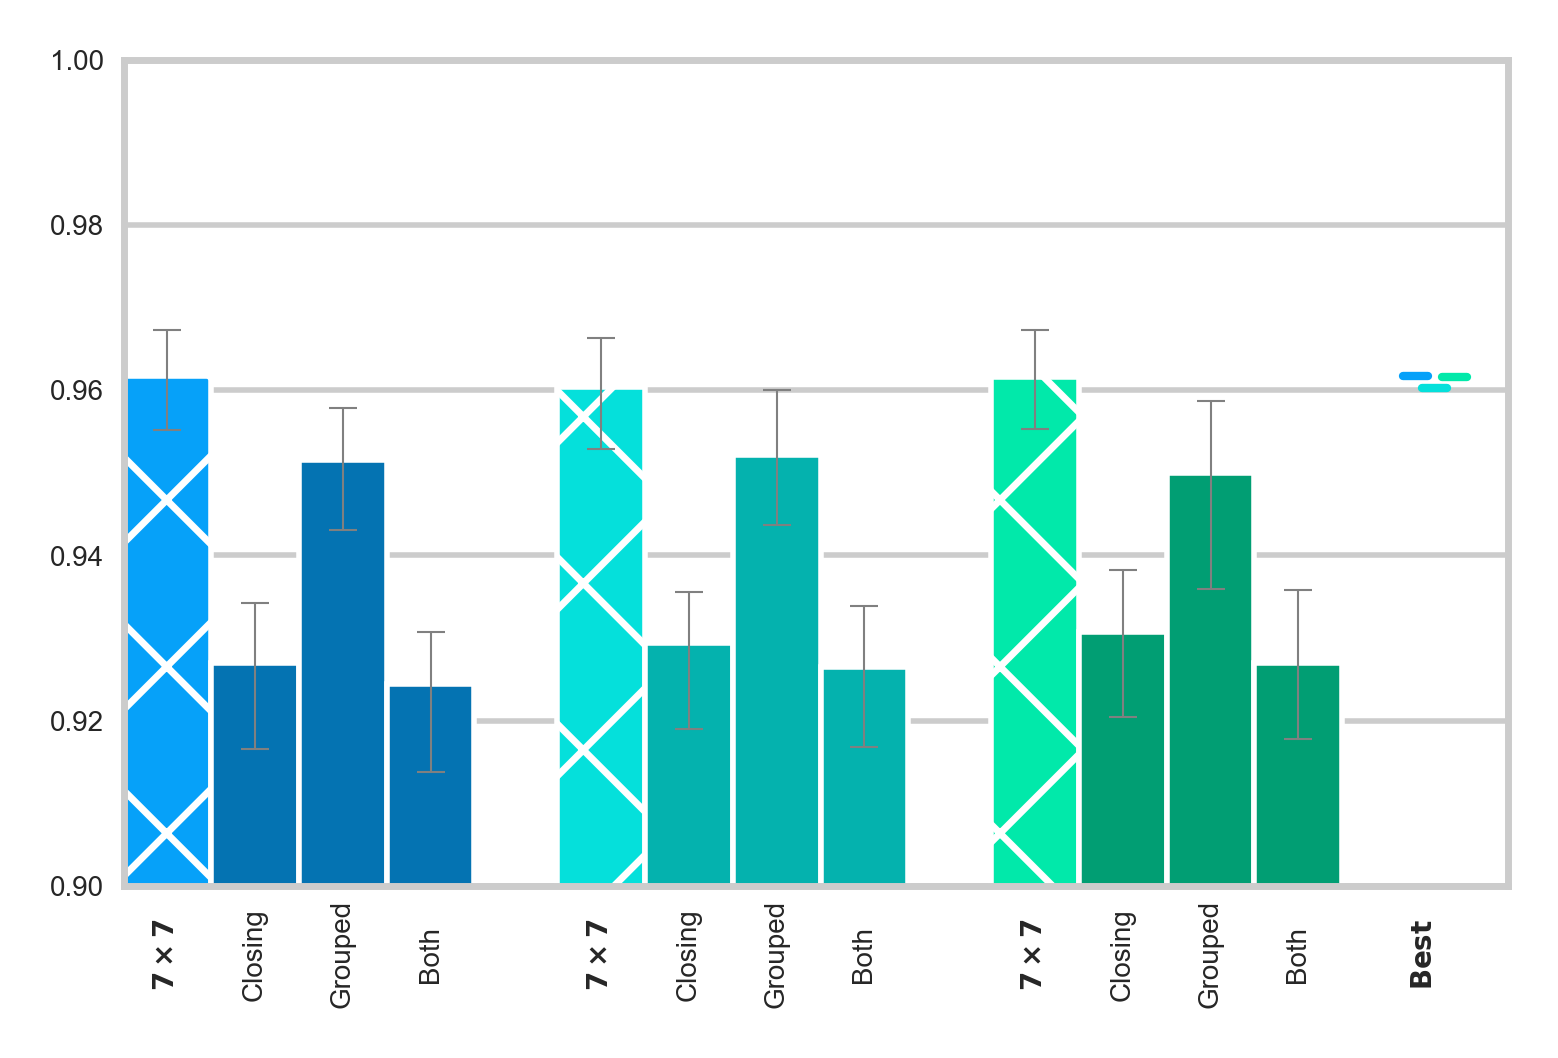

In [37]:
def plot_group_extra(
    ax: plt.Axes,
    tick_positions: list[float],
    tick_labels: list[str],
    group: pl.DataFrame,
    color: str,
    begin: float,
    width: float,
    highlight: str = None,
    higher_is_better: bool = True,
):
    best = (
        group.with_row_index()
        .top_k(1, by="mean", reverse=not higher_is_better)
        .item(0, column="index")
    )
    x = begin
    for i, (_kind, size, grouped, closing, low, mean, high) in enumerate(
        group.iter_rows()
    ):
        ax.bar(
            x,
            mean,
            width,
            align="edge",
            color=highlight if highlight and i == best else color,
            hatch="x" if highlight and i == best else "",
        )
        ax.errorbar(
            x + width / 2,
            mean,
            ((mean - low,), (high - mean,)),
            color="grey",
            capsize=2,
            linewidth=0.3,
            capthick=0.3,
        )
        tick_positions.append(x + width / 2)
        text = {
            (False, False): rf"{size}\times{size}",
            (False, True): r"Closing",
            (True, False): r"Grouped",
            (True, True): r"Both",
        }[(grouped, closing)]
        if i == best:
            label = rf"$\mathbf{{{text}}}$"
        else:
            label = rf"${text}$" if "\\" in text else text
        tick_labels.append(label)
        x += width


plot_results(
    plot_group_extra,
    preprocess_data(pl.read_parquet("./.data/closing_k_mnist.pq"), metric="acc"),
    # baseline=("iso-ss", 7),
    ylim=(0.9, 1.0),
    group_gap=0.06,
    x_tick_pad=5.0,
    save_path="./report/figures/results_closing_km.png",
)
plt.show()

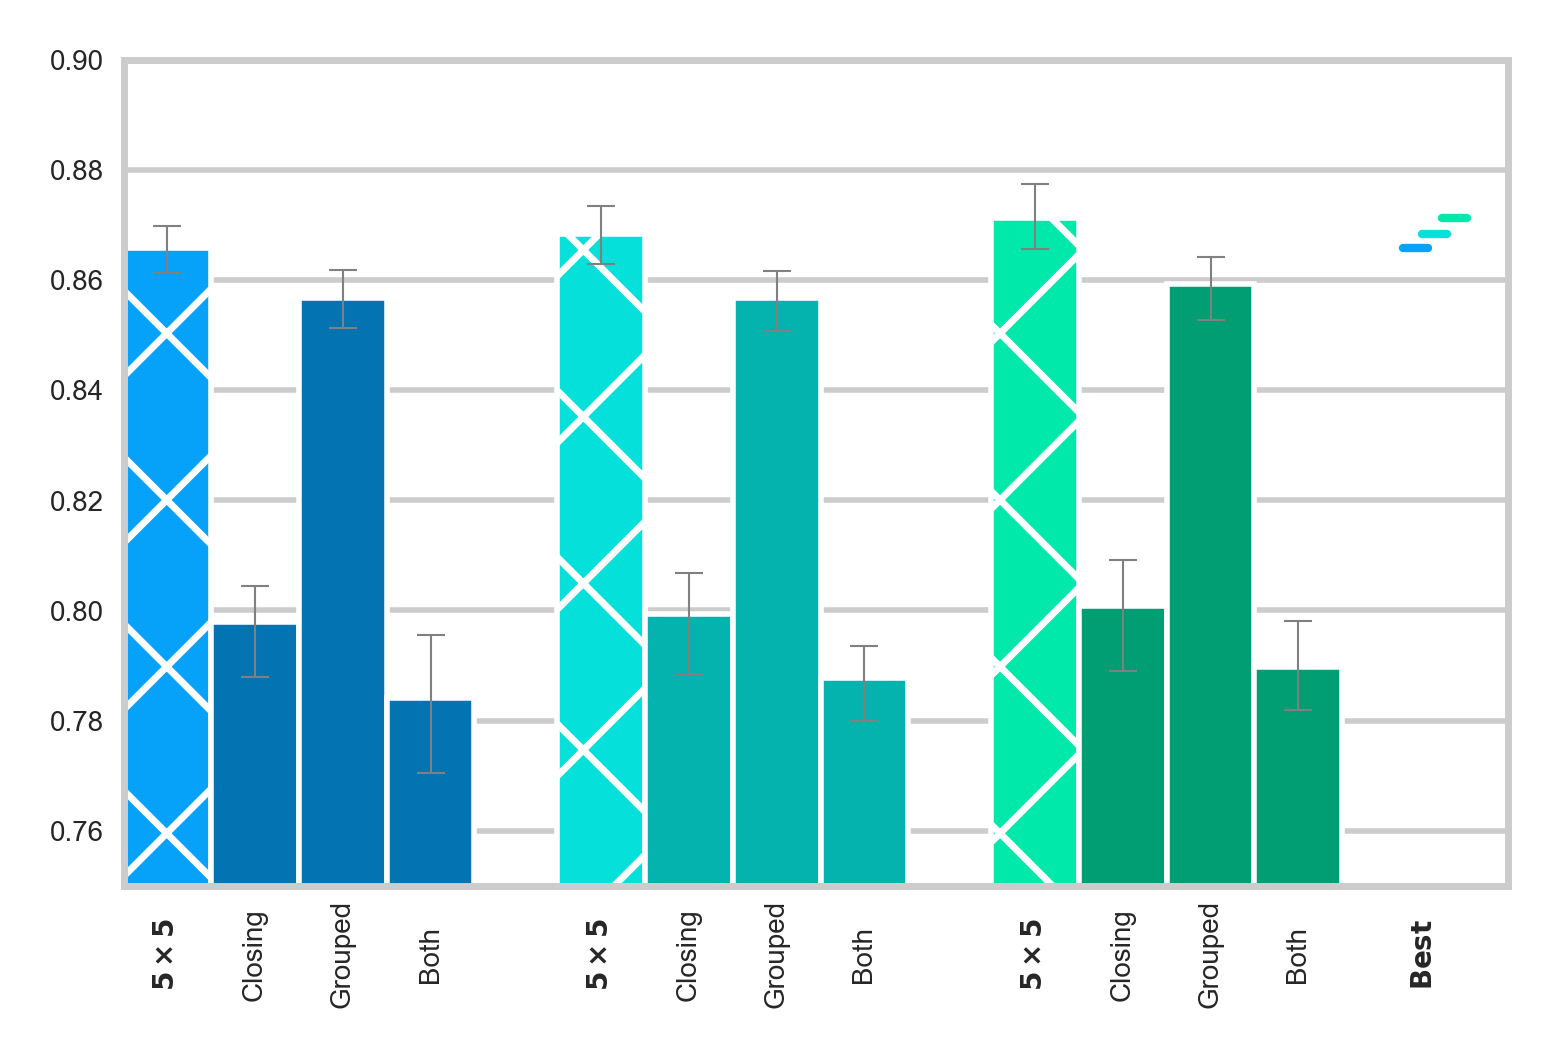

In [42]:
plot_results(
    plot_group_extra,
    preprocess_data(pl.read_parquet("./.data/closing_cifar10.pq"), metric="acc"),
    # baseline=("iso-ss", 7),
    ylim=(0.75, 0.9),
    group_gap=0.06,
    x_tick_pad=5.0,
    save_path="./report/figures/results_closing_cifar.png",
)
plt.show()

In [43]:
pl.read_parquet("./.data/nonlinear_k_mnist.pq")

aniso-7-log-0.8,standard-3-log-0.8,aniso-7-root-0.8,standard-3-root-0.8,aniso-7-log-0.85,standard-3-log-0.85,aniso-7-root-0.85,standard-3-root-0.85,aniso-7-log-0.9,standard-3-log-0.9,aniso-7-root-0.9,standard-3-root-0.9,aniso-7-log-0.95,standard-3-log-0.95,aniso-7-root-0.95,standard-3-root-0.95,aniso-7-log-1.0,standard-3-log-1.0,aniso-7-root-1.0,standard-3-root-1.0,aniso-7-log-1.05,standard-3-log-1.05,aniso-7-root-1.05,standard-3-root-1.05,aniso-7-log-1.1,standard-3-log-1.1,aniso-7-root-1.1,standard-3-root-1.1,aniso-7-log-1.15,standard-3-log-1.15,aniso-7-root-1.15,standard-3-root-1.15,aniso-7-log-1.2,standard-3-log-1.2,aniso-7-root-1.2,standard-3-root-1.2
struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7]
"{0.100369,0.0,0.182428,0.018243,36.427288,2.41033,38.837618}","{0.100369,0.0,0.182428,0.018243,38.173389,1.612623,39.786012}","{0.101454,0.0,0.184218,0.018422,41.692563,1.949593,43.642155}","{0.101454,0.0,0.184218,0.018422,42.347042,1.632706,43.979748}","{0.100369,0.0,0.182428,0.018243,37.592827,1.893758,39.486586}","{0.100369,0.0,0.182428,0.018243,38.171607,1.586246,39.757853}","{0.101454,0.0,0.184218,0.018422,41.706294,1.923681,43.629975}","{0.101454,0.0,0.184218,0.018422,42.353743,1.690558,44.044301}","{0.100369,0.0,0.182428,0.018243,37.740608,1.930459,39.671067}","{0.100369,0.0,0.182428,0.018243,38.276258,1.659423,39.935681}","{0.101454,0.0,0.184218,0.018422,41.748955,1.992513,43.741468}","{0.101454,0.0,0.184218,0.018422,42.413032,1.690187,44.103219}","{0.100369,0.0,0.182428,0.018243,37.773355,1.949605,39.72296}","{0.100369,0.0,0.182428,0.018243,38.338422,1.701397,40.03982}","{0.101454,0.0,0.184218,0.018422,41.849077,2.029326,43.878404}","{0.101454,0.0,0.184218,0.018422,42.480366,1.691455,44.171822}","{0.100369,0.0,0.182428,0.018243,36.477531,0.997999,37.475531}","{0.100369,0.0,0.182428,0.018243,35.820453,0.390132,36.210585}","{0.88303,0.845685,0.908504,0.883195,33.241167,0.942233,34.183401}","{0.902886,0.839873,0.936543,0.903056,32.515937,0.400277,32.916214}","{0.100369,0.0,0.182428,0.018243,37.869166,2.13027,39.999437}","{0.100369,0.0,0.182428,0.018243,38.443504,1.73978,40.183285}","{0.101454,0.0,0.184218,0.018422,41.918114,2.069184,43.987298}","{0.101454,0.0,0.184218,0.018422,42.561126,1.769547,44.330673}","{0.100369,0.0,0.182428,0.018243,37.924056,2.061294,39.98535}","{0.100369,0.0,0.182428,0.018243,38.46951,1.794703,40.264213}","{0.101454,0.0,0.184218,0.018422,41.930993,2.07401,44.005003}","{0.101454,0.0,0.184218,0.018422,42.576172,1.808262,44.384434}","{0.100369,0.0,0.182428,0.018243,38.032685,2.081709,40.114394}","{0.100369,0.0,0.182428,0.018243,38.516069,1.785698,40.301767}","{0.101454,0.0,0.184218,0.018422,42.010864,2.143142,44.154006}","{0.101454,0.0,0.184218,0.018422,42.586227,1.820347,44.406574}","{0.100369,0.0,0.182428,0.018243,38.040518,2.103411,40.143929}","{0.100369,0.0,0.182428,0.018243,38.552125,1.793892,40.346016}","{0.101454,0.0,0.184218,0.018422,42.040169,2.140903,44.181071}","{0.101454,0.0,0.184218,0.018422,42.705753,1.889275,44.595028}"
"{0.099284,0.0,0.180634,0.018063,35.847842,0.17306,36.020902}","{0.099284,0.0,0.180634,0.018063,35.481712,0.186097,35.667809}","{0.101454,0.0,0.184218,0.018422,39.199651,0.172849,39.3725}","{0.101454,0.0,0.184218,0.018422,38.951648,0.180863,39.132511}","{0.099284,0.0,0.180634,0.018063,35.842454,0.208272,36.050726}","{0.099284,0.0,0.180634,0.018063,35.504981,0.213051,35.718032}","{0.101454,0.0,0.184218,0.018422,39.233807,0.192397,39.426204}","{0.101454,0.0,0.184218,0.018422,38.992984,0.210542,39.203525}","{0.099501,0.0,0.180993,0.018099,35.942981,0.24951,36.192491}","{0.099284,0.0,0.180634,0.018063,35.579141,0.255645,35.834787}","{0.101454,0.0,0.184218,0.018422,39

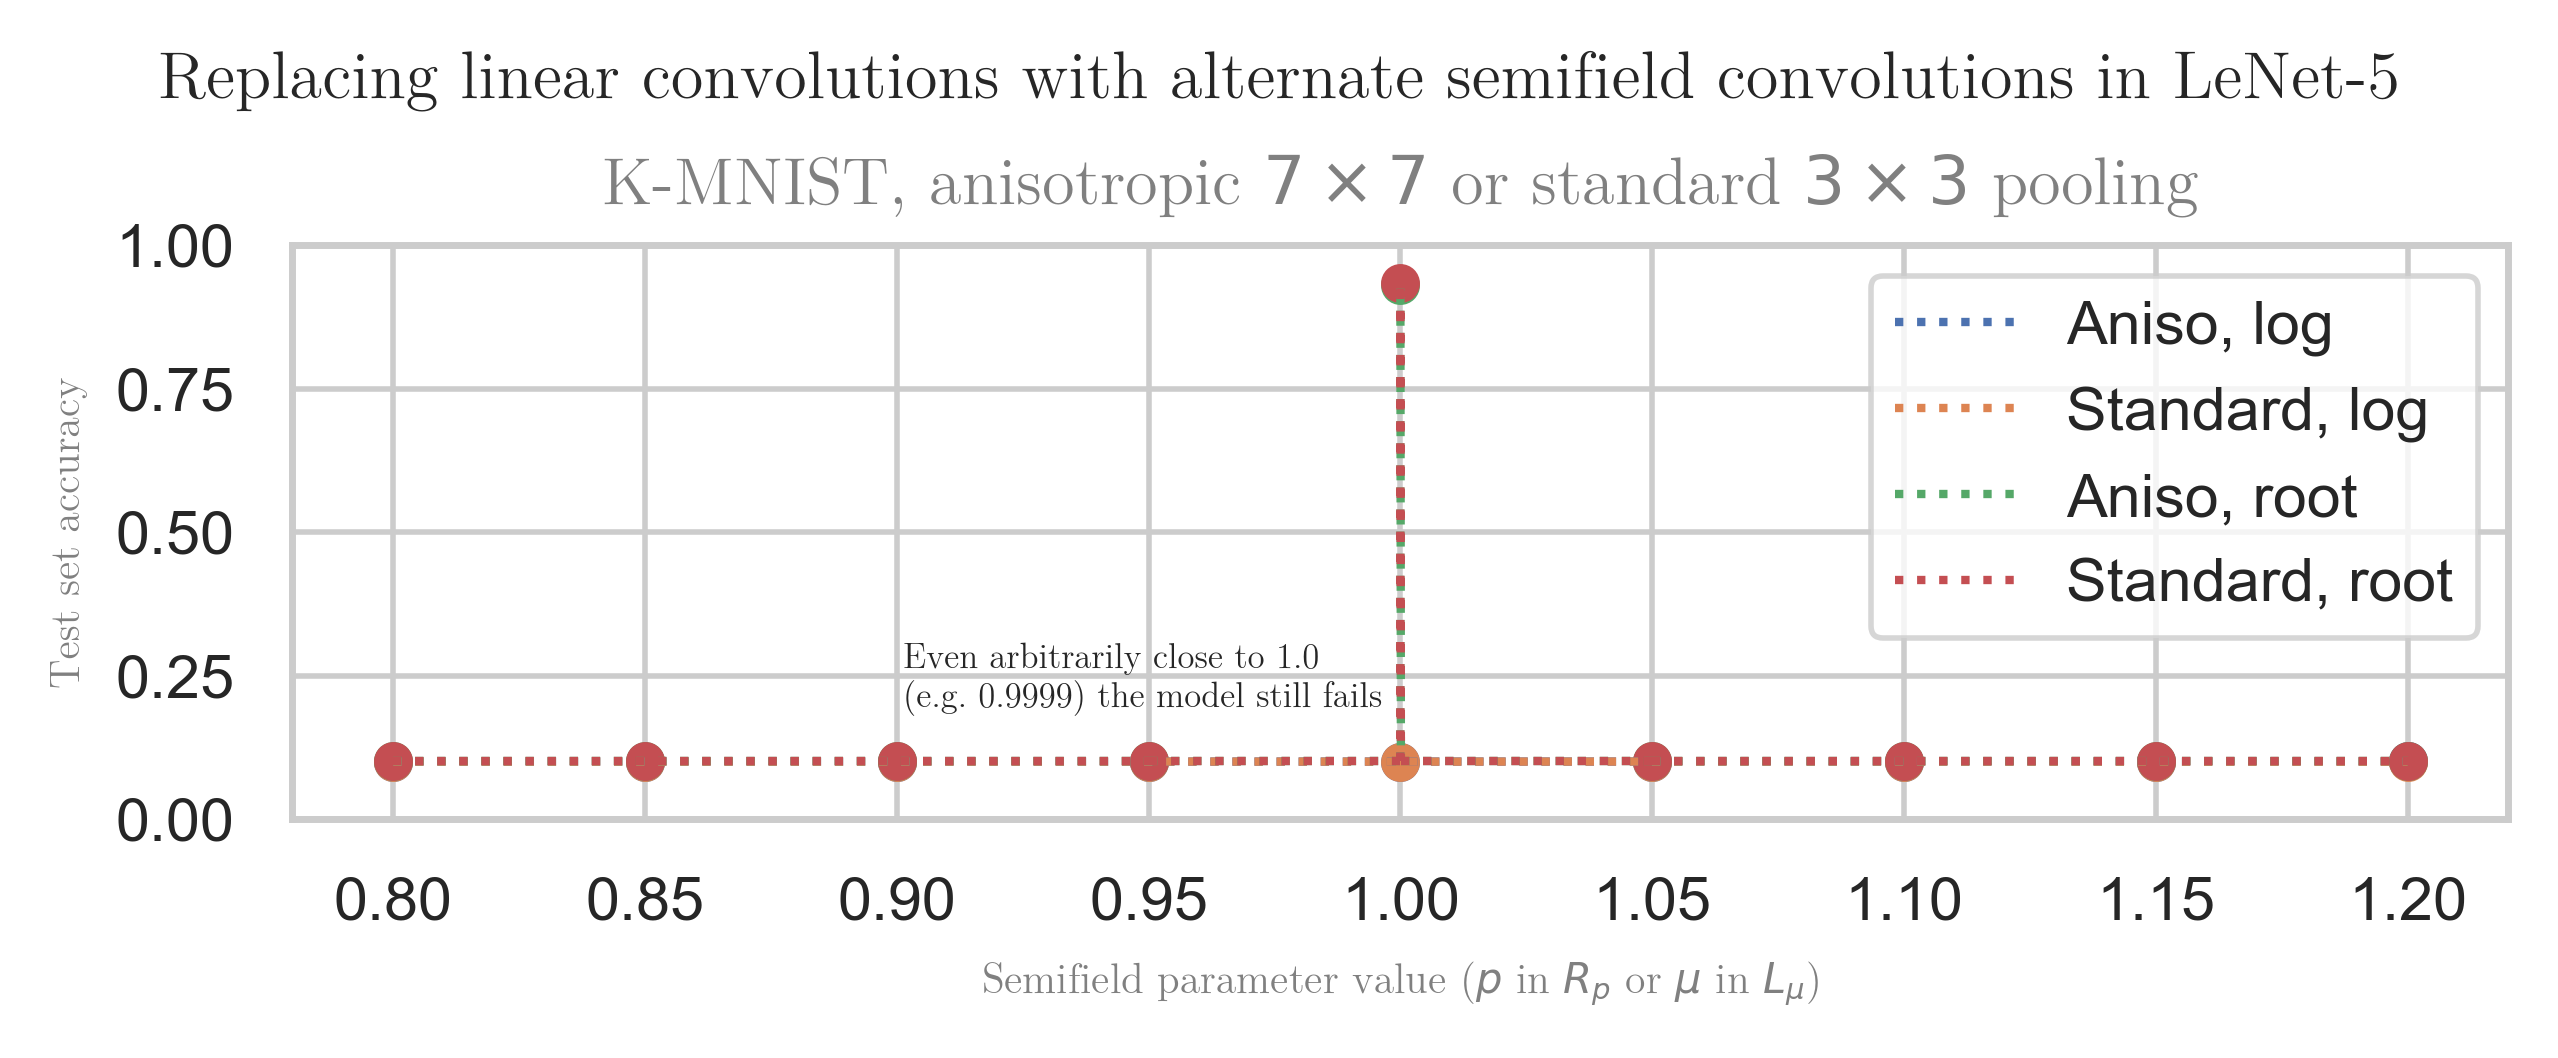

In [125]:
def alt_preprocess(
    data: pl.DataFrame, metric: str = "acc", low: float = 0.05, high: float = 0.95
):
    return (
        data.select(
            pl.all()
            .implode()
            .list.eval(
                pl.struct(
                    mean=pl.element().struct.field(metric).mean(),
                    high=pl.element().struct.field(metric).quantile(high),
                    low=pl.element().struct.field(metric).quantile(low),
                )
            )
            .list.get(0)
        )
        .transpose(include_header=True, column_names=["metric"], header_name="kind")
        .lazy()
        .select(
            pl.col("kind")
            .str.split_exact("-", 3)
            .struct.rename_fields(["kind", "size", "semifield", "param"])
            .struct.with_fields(
                size=pl.field("size").cast(int),
                param=pl.field("param").cast(float),
            )
            .struct.unnest(),
            pl.col("metric").struct.unnest(),
        )
        .collect()
    )


import numpy as np

_, _ax = plt.subplots(layout="compressed", dpi=500, figsize=(5, 2))

for (kind, semifield), group in (
    alt_preprocess(pl.read_parquet("./.data/nonlinear_k_mnist.pq"))
    .sort("param", "semifield", "kind")
    .group_by("kind", "semifield", maintain_order=True)
):
    if semifield == "log":
        _col = _ax.plot(
            group["param"],
            group["mean"],
            label=f"{kind.capitalize()}, {semifield}",
            linestyle="dotted",
        )[0].get_color()
    else:
        _col = _ax.plot(
            group["param"][:4],
            group["mean"][:4],
            label=f"{kind.capitalize()}, {semifield}",
            linestyle="dotted",
        )[0].get_color()
        # See measurements in the next cell.
        _ax.plot(
            (group["param"][3], 0.99999),
            (group["mean"][3], group["mean"][3]),
            linestyle="dotted",
            color=_col,
        )
        _ax.plot(
            (0.99999, 1.0, 1.0001), group["mean"][3:6], linestyle="dotted", color=_col
        )
        _ax.plot(
            (1.0001, group["param"][5]),
            (group["mean"][5], group["mean"][5]),
            linestyle="dotted",
            color=_col,
        )
        _ax.plot(group["param"][5:], group["mean"][5:], linestyle="dotted", color=_col)
    _ax.scatter(group["param"], group["mean"], color=_col)


plt.text(
    0.9013,
    0.195,
    "Even arbitrarily close to 1.0\n(e.g. 0.9999) the model still fails",
    font="Latin Modern Roman",
    fontsize=5,
)
plt.legend()
plt.ylim(0, 1)
plt.ylabel("Test set accuracy", fontsize=6, color="grey", font="Latin Modern Roman")
plt.xlabel(
    r"Semifield parameter value ($p$ in $R_p$ or $\mu$ in $L_\mu$)",
    fontsize=6,
    color="grey",
    font="Latin Modern Roman",
)
plt.suptitle(
    "Replacing linear convolutions with alternate semifield convolutions in LeNet-5",
    font="Latin Modern Roman",
)
plt.title(
    "K-MNIST, anisotropic $7\\times7$ or standard $3\\times3$ pooling",
    color="grey",
    fontsize=3,
    font="Latin Modern Roman",
)
plt.savefig("./report/figures/results_nonlin.png")
plt.show()

In [98]:
pl.read_parquet("./.data/nonlinear_k_mnist_zoom.pq")

aniso-7-root-0.9999999999999999,standard-3-root-0.9999999999999999,aniso-7-log-0.9999999999999999,standard-3-log-0.9999999999999999,aniso-7-root-1.0,standard-3-root-1.0,aniso-7-log-1.0,standard-3-log-1.0
struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7],struct[7]
"{0.101454,0.0,0.184218,0.018422,31.996791,0.314448,32.311238}","{0.101454,0.0,0.184218,0.018422,31.838783,0.286834,32.125617}","{0.098958,0.0,0.180095,0.018009,28.670682,0.395146,29.065827}","{0.098958,0.0,0.180095,0.018009,28.395966,0.353821,28.749787}","{0.869683,0.814255,0.908272,0.86961,26.397533,0.352449,26.749982}","{0.894965,0.852637,0.921901,0.894714,26.098737,0.312143,26.41088}","{0.098958,0.0,0.180095,0.018009,28.71693,0.449225,29.166155}","{0.098958,0.0,0.180095,0.018009,28.467043,0.377757,28.844801}"
"{0.101454,0.0,0.184218,0.018422,30.900811,0.161837,31.062649}","{0.101454,0.0,0.184218,0.018422,30.759849,0.162245,30.922094}","{0.101454,0.0,0.184218,0.018422,28.53673,0.191658,28.728388}","{0.100694,0.0,0.182965,0.018297,28.261437,0.192778,28.454215}","{0.897027,0.87095,0.915847,0.896858,26.215952,0.198784,26.414736}","{0.915473,0.881057,0.932203,0.915413,25.924363,0.199162,26.123525}","{0.101454,0.0,0.184218,0.018422,28.562483,0.229072,28.791555}","{0.100694,0.0,0.182965,0.018297,28.315088,0.230004,28.545092}"
"{0.101454,0.0,0.184218,0.018422,30.906315,0.172897,31.079212}","{0.101454,0.0,0.184218,0.018422,30.754173,0.161646,30.915819}","{0.100369,0.0,0.182428,0.018243,28.521311,0.206455,28.727766}","{0.100369,0.0,0.182428,0.018243,28.261563,0.193425,28.454989}","{0.904188,0.87013,0.917885,0.904195,26.215052,0.210726,26.425778}","{0.919705,0.877722,0.941676,0.919519,25.918278,0.197737,26.116015}","{0.100369,0.0,0.182428,0.018243,28.557638,0.229527,28.787165}","{0.100369,0.0,0.182428,0.018243,28.318777,0.231041,28.549818}"
"{0.101454,0.0,0.184218,0.018422,30.921606,0.16425,31.085857}","{0.101454,0.0,0.184218,0.018422,30.76121,0.162957,30.924168}","{0.101454,0.0,0.184218,0.018422,28.526938,0.207056,28.733994}","{0.101454,0.0,0.184218,0.018422,28.260893,0.203386,28.464279}","{0.918728,0.886823,0.946674,0.918644,26.237273,0.197525,26.434798}","{0.92806,0.896396,0.946341,0.927898,25.909213,0.209504,26.118717}","{0.101454,0.0,0.184218,0.018422,28.570248,0.244853,28.815101}","{0.101454,0.0,0.184218,0.018422,28.320129,0.228987,28.549116}"
"{0.101454,0.0,0.184218,0.018422,30.918549,0.173411,31.09196}","{0.101454,0.0,0.184218,0.018422,30.753027,0.162601,30.915628}","{0.099826,0.0,0.181531,0.018153,28.521497,0.205203,28.7267}","{0.099501,0.0,0.180993,0.018099,28.266357,0.206519,28.472876}","{0.916341,0.85699,0.940022,0.916443,26.223885,0.209532,26.433417}","{0.933485,0.903888,0.957219,0.933409,25.908166,0.19565,26.103815}","{0.099826,0.0,0.181531,0.018153,28.571127,0.232014,28.803142}","{0.099501,0.0,0.180993,0.018099,28.318837,0.230537,28.549374}"
